# PubMed 200k RCT: Dataset for Sequential Sentence Classification

In [4]:
# Importing modules
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import random
import string

# Custom
from helper_function.niffo_helper import calculate_result
from helper_function import niffo_plotter, preprocessing

## Getting Data Ready
**Link:** https://github.com/Franck-Dernoncourt/pubmed-rct

`!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git`

In [33]:
# Using 20k dataset for the initial model
data_dir = "Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

### Preprocessing Data

In [34]:
train_data = preprocessing.get_raw_data(data_dir + "train.txt")
val_data = preprocessing.get_raw_data(data_dir + "dev.txt")
test_data = preprocessing.get_raw_data(data_dir + "test.txt")

In [35]:
len(train_data), len(val_data), len(test_data)

(180040, 30212, 30135)

In [36]:
train_data[0]

{'target': 'OBJECTIVE',
 'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'line_number': 0,
 'total_lines': 11}

### Making pandas DataFrame

In [37]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
val_df = pd.DataFrame(val_data)

In [38]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [39]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [40]:
val_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


### Getting the sentences

In [41]:
train_sen = train_df["text"].tolist()
val_sen = val_df["text"].tolist()
test_sen = test_df["text"].tolist()

In [42]:
train_sen[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

### Making numerical labels

In [43]:
ohe = OneHotEncoder(sparse=False)
train_labels = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
test_labels = ohe.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))
val_labels = ohe.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))

In [44]:
tf.constant(train_labels)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Encoding labels

In [45]:
label_encoder = LabelEncoder()
etrain_labels = label_encoder.fit_transform(train_df["target"].to_numpy())
etest_labels = label_encoder.fit_transform(test_df["target"].to_numpy())
eval_labels = label_encoder.fit_transform(val_df["target"].to_numpy())

In [46]:
etrain_labels, etest_labels, eval_labels

(array([3, 2, 2, ..., 4, 1, 1]),
 array([0, 4, 4, ..., 4, 4, 1]),
 array([0, 0, 3, ..., 4, 1, 1]))

In [47]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Model 0: BaseLine model

(TF-IDF Multinomial Naive Bayes Classifier).

**Score:**

`accuracy': 71.66%`

`precision': 0.7124322482375202`

`recall': 0.716674962667994,`

`f1-score': 0.6925101703856846`

In [17]:
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])
model_0.fit(train_sen, etrain_labels)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
model_0.score(val_sen, eval_labels)

0.7218323844829869

In [19]:
model_0_preds = model_0.predict(test_sen)

In [20]:
model_0_res = calculate_result(y_true=etest_labels, y_predict=model_0_preds)
model_0_res

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1-score': 0.6925101703856846}

In [48]:
mat_class = [i[0] + i[1:].lower() for i in class_names]

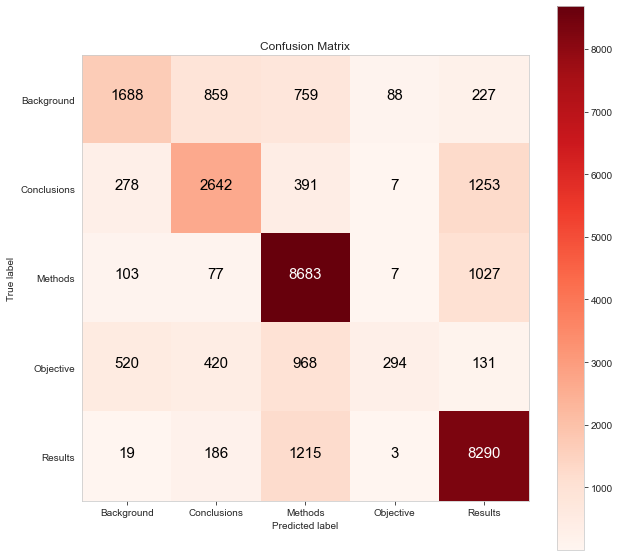

In [22]:
niffo_plotter.plot_confusion_matrix(y_true=etest_labels, y_predict=model_0_preds, classes=mat_class)

## Model 1: Convolutional 1-D model
(Conv1D with token embeddings)

**Score:**

`accuracy': 78.52%`

`precision': 0.7817069791201003`

`recall': 0.7852663016426082`
 
`f1-score': 0.782223028043873`

In [23]:
sen_len = [len(sen.split()) for sen in train_sen]
np.mean(sen_len)

26.338269273494777

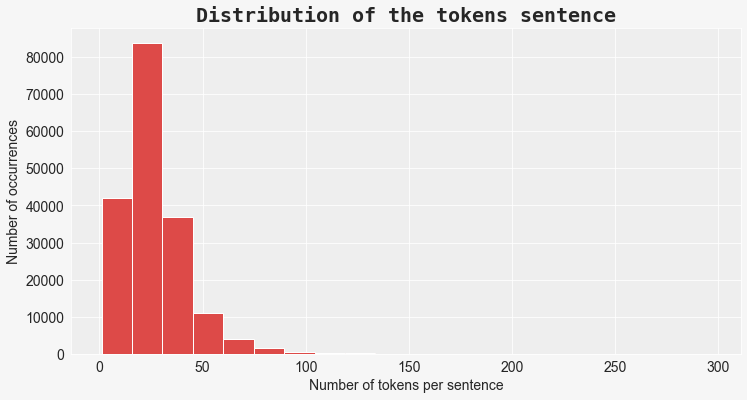

In [24]:
niffo_plotter.plot_histogram(data=sen_len,
                             xlabel="Number of tokens per sentence",
                             ylabel="Number of occurrences",
                             title="Distribution of the tokens sentence",
                             bins=20)

In [25]:
# The graph represents taking 95% of the data is safe for the sequences length output
out_seq_len = int(np.percentile(sen_len, 95))
out_seq_len

55

In [26]:
max(sen_len) # Outlier

296

### Creating text vector and embedding layer

In [27]:
# Preparing text vector
text_vector = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=68000,
                                                                          output_sequence_length=out_seq_len)
text_vector.adapt(train_sen)

In [28]:
embed = tf.keras.layers.Embedding(input_dim=68000,
                                 output_dim=128,
                                 input_length=out_seq_len)

In [29]:
text_vector(["checking if it is working"])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[61684,   324,   185,    20,  1615,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int64)>

### Creating datasets for loading the data efficiently

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sen, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sen, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sen, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [31]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Preparing convolutional model architecture

In [32]:
# Input layer
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="input_layer")

# Text Vectorization
x = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=68000,
                                                                output_sequence_length=55)
x.adapt(train_sen)

# Apply text vectorization on inputs
x = x(inputs)

# Adding Embedding layer
x = tf.keras.layers.Embedding(input_dim=68000,
                             output_dim=128,
                             input_length=55)(x)
# Adding Conv1D layer
x = tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           activation="relu",
                           name="conv1D_layer",
                           padding="same")(x)
# Applying pooling layer
x = tf.keras.layers.GlobalAveragePooling1D()(x)

# Adding output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Combining into model_1
model_1 = tf.keras.Model(inputs, outputs)

# Compiling the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [33]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 55, 128)           8704000   
                                                                 
 conv1D_layer (Conv1D)       (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 5)                 325   

In [34]:
# Fitting the data into the model
his_1 = model_1.fit(train_dataset,
            epochs=10,
            validation_data=valid_dataset)

Epoch 1/10
5627/5627 [==============================] - 74s 12ms/step - loss: 0.6150 - accuracy: 0.7762 - val_loss: 0.5365 - val_accuracy: 0.8098
Epoch 2/10
5627/5627 [==============================] - 65s 12ms/step - loss: 0.4511 - accuracy: 0.8422 - val_loss: 0.5348 - val_accuracy: 0.8108
Epoch 3/10
5627/5627 [==============================] - 63s 11ms/step - loss: 0.3710 - accuracy: 0.8731 - val_loss: 0.5676 - val_accuracy: 0.8065
Epoch 4/10
5627/5627 [==============================] - 63s 11ms/step - loss: 0.3073 - accuracy: 0.8974 - val_loss: 0.6257 - val_accuracy: 0.7991
Epoch 5/10
5627/5627 [==============================] - 63s 11ms/step - loss: 0.2538 - accuracy: 0.9174 - val_loss: 0.7062 - val_accuracy: 0.7928
Epoch 6/10
5627/5627 [==============================] - 63s 11ms/step - loss: 0.2085 - accuracy: 0.9338 - val_loss: 0.7989 - val_accuracy: 0.7860
Epoch 7/10
5627/5627 [==============================] - 63s 11ms/step - loss: 0.1704 - accuracy: 0.9475 - val_loss: 0.9024 -

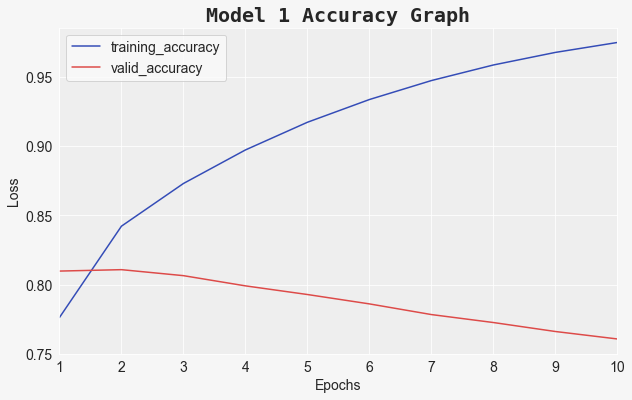

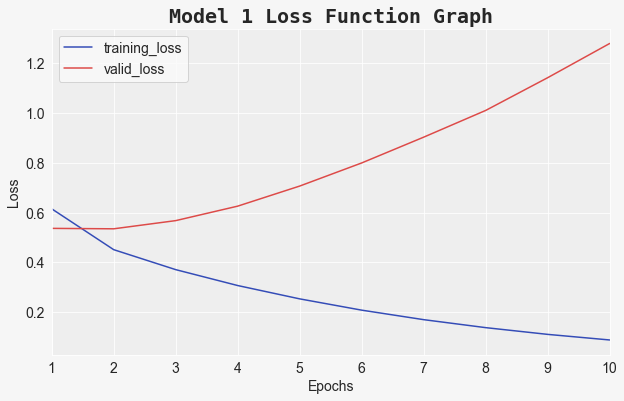

In [35]:
niffo_plotter.plot_model_history_accuracy(his_1, model_name="Model 1")
niffo_plotter.plot_model_history_loss(his_1, model_name="Model 1")

In [36]:
# Predicting test data
model_1_preds = model_1.predict(test_dataset)
model_1_preds

array([[8.8137621e-01, 8.7725744e-03, 1.1737289e-02, 9.7450837e-02,
        6.6305499e-04],
       [1.2896091e-05, 4.9981597e-04, 7.7115119e-01, 9.6897947e-09,
        2.2833616e-01],
       [1.4353562e-07, 5.0533356e-07, 9.9919134e-01, 5.1993959e-07,
        8.0761401e-04],
       ...,
       [1.0850150e-07, 3.3801378e-04, 2.2162242e-06, 4.7073293e-08,
        9.9965966e-01],
       [1.0905213e-04, 1.5759956e-02, 4.5688570e-04, 1.5342990e-05,
        9.8365873e-01],
       [2.2769099e-07, 4.2553191e-04, 1.2224595e-04, 3.4281668e-16,
        9.9945194e-01]], dtype=float32)

In [37]:
model_1_preds = np.argmax(model_1_preds, axis=1)
model_1_preds

array([0, 2, 2, ..., 4, 4, 4], dtype=int64)

In [38]:
calculate_result(y_true=etest_labels, y_predict=model_1_preds)

{'accuracy': 75.35423925667828,
 'precision': 0.750141878258074,
 'recall': 0.7535423925667828,
 'f1-score': 0.7513662138714329}

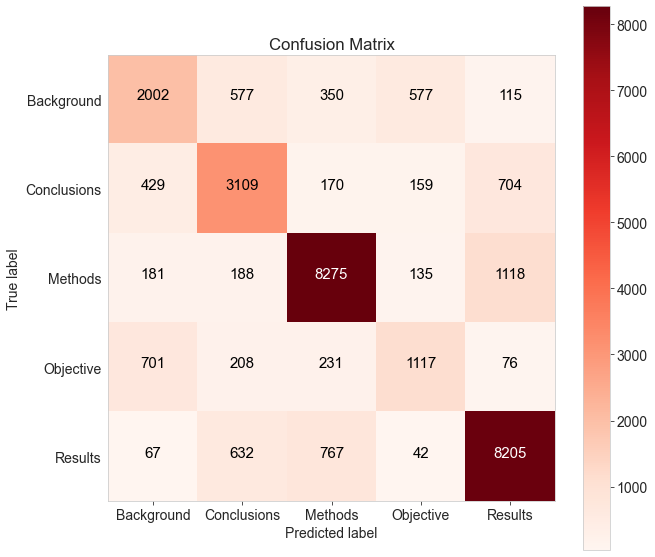

In [42]:
niffo_plotter.plot_confusion_matrix(y_true=etest_labels, y_predict=model_1_preds, classes=mat_class)

## Model 2: Transfer learning Feature Extraction model

Pretrained embedding layer link - https://tfhub.dev/google/universal-sentence-encoder/4

**Score:**

`accuracy: 76.76455948232952%`

`precision: 0.7651474813371973`

`recall: 0.7676455948232952`

`f1-score: 0.763595417021131`

In [43]:
pretrained_dir = "Pretrained/universal-sentence-encoder_4" # or Pretrained embedding layer link

In [44]:
# Loading embedding layer
embedding_layer = hub.KerasLayer(pretrained_dir, trainable=False, name="universal_sentence_encoder")

In [45]:
# Testing embedding layer
sen = random.choice(train_sen)
print(f"Choosen sentence:\n{sen}")
embedded_sen = embedding_layer([sen])
print(f"\nApplied embedding layer:\n{embedded_sen[0][:24]}\n\nShape: {embedded_sen.shape}")

Choosen sentence:
this randomised controlled trial ( actrn@ ) was conducted among @ older people .

Applied embedding layer:
[ 0.04351817  0.04226871 -0.00070434  0.00395051 -0.10151313  0.03376924
  0.04358111  0.00145004  0.03251427 -0.03784496  0.02481652  0.0133364
  0.09348086  0.05694416  0.03832217  0.01172244 -0.08523145  0.03323101
  0.00624021 -0.06190278 -0.01295863  0.00185944 -0.03759662 -0.07564712]

Shape: (1, 512)


In [46]:
# Creating input layer
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="input_layer")

# Passing inputs to the embedding layer
x = embedding_layer(inputs)

# adding layers
x = tf.keras.layers.Dense(128, activation="relu")(x)

# Creating output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Combining inputs and outputs
model_2 = tf.keras.Model(inputs, outputs, name="output_layer")


# Compiling the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [47]:
model_2.summary()

Model: "output_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [48]:
# Fitting the train and validation data
his_2 = model_2.fit(train_dataset,
                    epochs=10,
                    validation_data=valid_dataset)

Epoch 1/10
5627/5627 [==============================] - 86s 15ms/step - loss: 0.7282 - accuracy: 0.7224 - val_loss: 0.6577 - val_accuracy: 0.7493
Epoch 2/10
5627/5627 [==============================] - 82s 15ms/step - loss: 0.6349 - accuracy: 0.7597 - val_loss: 0.6237 - val_accuracy: 0.7620
Epoch 3/10
5627/5627 [==============================] - 83s 15ms/step - loss: 0.6005 - accuracy: 0.7731 - val_loss: 0.6094 - val_accuracy: 0.7684
Epoch 4/10
5627/5627 [==============================] - 82s 15ms/step - loss: 0.5785 - accuracy: 0.7819 - val_loss: 0.6031 - val_accuracy: 0.7712
Epoch 5/10
5627/5627 [==============================] - 82s 15ms/step - loss: 0.5620 - accuracy: 0.7883 - val_loss: 0.6002 - val_accuracy: 0.7720
Epoch 6/10
5627/5627 [==============================] - 82s 14ms/step - loss: 0.5485 - accuracy: 0.7937 - val_loss: 0.5998 - val_accuracy: 0.7714
Epoch 7/10
5627/5627 [==============================] - 82s 15ms/step - loss: 0.5373 - accuracy: 0.7980 - val_loss: 0.6014 -

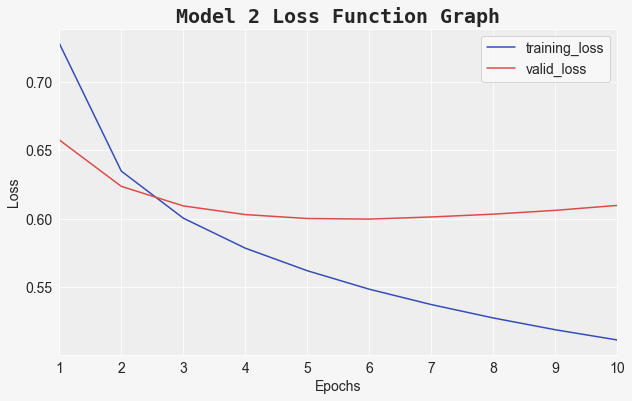

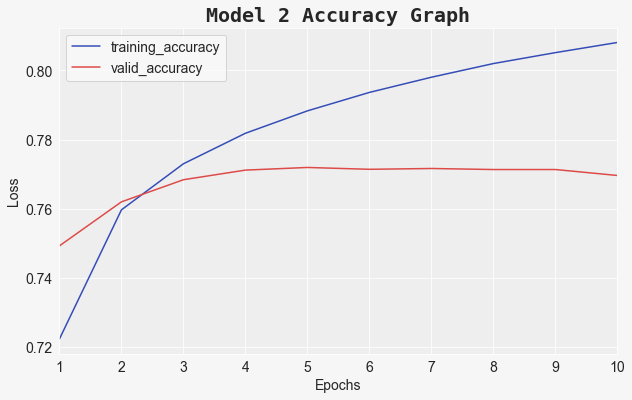

In [49]:
niffo_plotter.plot_model_history_loss(his_2, model_name="Model 2")
niffo_plotter.plot_model_history_accuracy(his_2, model_name="Model 2")

In [50]:
model_2_preds = tf.argmax(model_2.predict(test_dataset), axis=1)
calculate_result(y_true=etest_labels, y_predict=model_2_preds)

{'accuracy': 76.49908743985398,
 'precision': 0.7622524480524063,
 'recall': 0.7649908743985399,
 'f1-score': 0.7610555696436997}

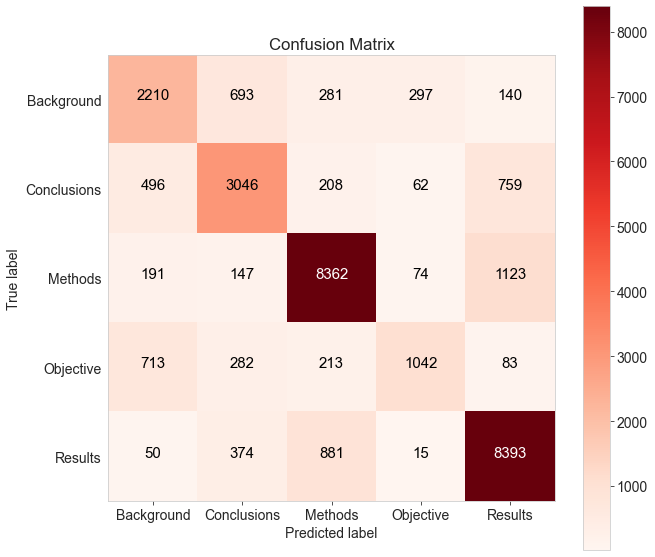

In [51]:
niffo_plotter.plot_confusion_matrix(y_true=etest_labels, y_predict=model_2_preds, classes=mat_class)

## Model 3: Convolutional 1-D with Character embeddings

**Score:**

`accuracy: 73.48%`

`precision: 0.7333355362987595`

`recall: 0.7347270615563298`

`f1-score: 0.7283699804820812`


In [52]:
train_chars = [preprocessing.split_chars(sen) for sen in train_sen]
val_chars = [preprocessing.split_chars(sen) for sen in val_sen]
test_chars = [preprocessing.split_chars(sen) for sen in test_sen]

In [53]:
train_chars[:2][:20]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [54]:
# figuring out output sequence length
char_lens = [float(len(sen)) for sen in train_sen]
tf.reduce_mean(char_lens)

<tf.Tensor: shape=(), dtype=float32, numpy=149.36626>

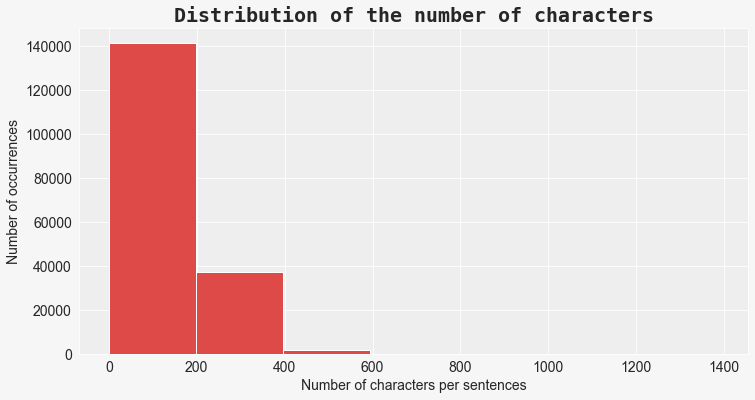

In [55]:
# Checking the distribution of the characters
niffo_plotter.plot_histogram(char_lens, bins=7, xlabel="Number of characters per sentences",
                            ylabel="Number of occurrences",
                            title="Distribution of the number of characters")

In [56]:
# Finding character length that covers 95% of the sequences
os_length = int(np.percentile(char_lens, 95))
os_length

290

### Building model

In [57]:
# Creating input layer
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="input_layer")

# Creating text vectorization layer
x = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=70,
                                                                output_sequence_length=os_length)
x.adapt(train_chars)

char_vocab = x.get_vocabulary()

# Adding text vectorization layer to the model
x = x(inputs)

# Adding embedding layer
x = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                             output_dim=25,
                             mask_zero=False,
                             name="character_embedding_layer")(x)
# Adding Convulational layers
x = tf.keras.layers.Conv1D(filters=64,
                          kernel_size=5,
                          activation="relu",
                           padding="same",
                          name="convulational_layer_1D")(x)
# Adding pooling layer
x = tf.keras.layers.GlobalMaxPool1D(name="pooling_layer")(x)

# Creating output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Combining inputs and outputs
model_3 = tf.keras.Model(inputs, outputs, name="model_3")

# Compiling model 3
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [58]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 character_embedding_layer (  (None, 290, 25)          700       
 Embedding)                                                      
                                                                 
 convulational_layer_1D (Con  (None, 290, 64)          8064      
 v1D)                                                            
                                                                 
 pooling_layer (GlobalMaxPoo  (None, 64)               0         
 ling1D)                                                   

In [59]:
# Creating character datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [60]:
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [61]:
# Fitting data
his_3 = model_3.fit(train_char_dataset, epochs=10, validation_data=val_char_dataset)

Epoch 1/10
5627/5627 [==============================] - 36s 6ms/step - loss: 0.8881 - accuracy: 0.6518 - val_loss: 0.7855 - val_accuracy: 0.6929
Epoch 2/10
5627/5627 [==============================] - 35s 6ms/step - loss: 0.7425 - accuracy: 0.7166 - val_loss: 0.7496 - val_accuracy: 0.7115
Epoch 3/10
5627/5627 [==============================] - 35s 6ms/step - loss: 0.7082 - accuracy: 0.7326 - val_loss: 0.7233 - val_accuracy: 0.7247
Epoch 4/10
5627/5627 [==============================] - 35s 6ms/step - loss: 0.6847 - accuracy: 0.7426 - val_loss: 0.7068 - val_accuracy: 0.7316
Epoch 5/10
5627/5627 [==============================] - 34s 6ms/step - loss: 0.6706 - accuracy: 0.7492 - val_loss: 0.6927 - val_accuracy: 0.7372
Epoch 6/10
5627/5627 [==============================] - 35s 6ms/step - loss: 0.6612 - accuracy: 0.7524 - val_loss: 0.6878 - val_accuracy: 0.7400
Epoch 7/10
5627/5627 [==============================] - 35s 6ms/step - loss: 0.6541 - accuracy: 0.7553 - val_loss: 0.6855 - val_ac

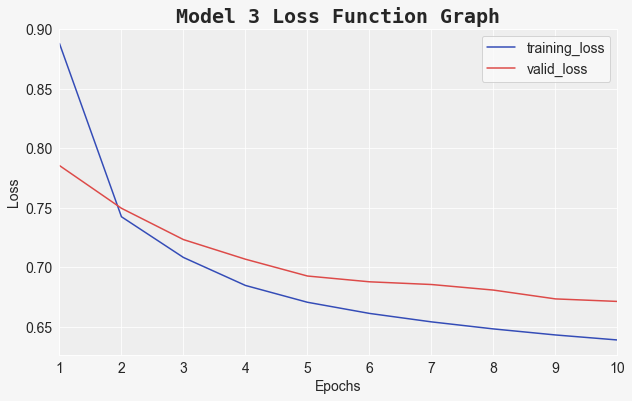

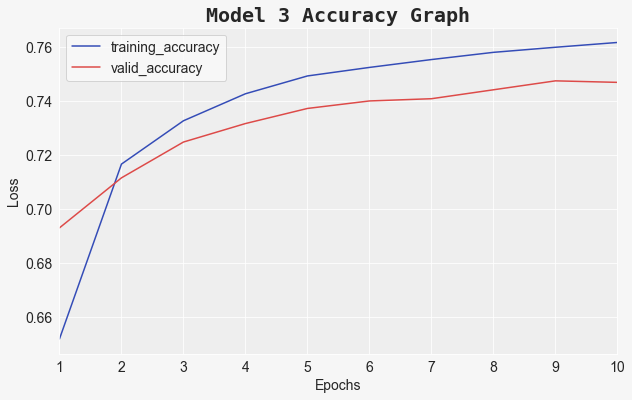

In [62]:
niffo_plotter.plot_model_history_loss(his_3, model_name="Model 3")
niffo_plotter.plot_model_history_accuracy(his_3, model_name="Model 3")

In [63]:
model_3_preds = tf.argmax(model_3.predict(test_char_dataset), axis=1)
calculate_result(y_true=etest_labels, y_predict=model_3_preds)

{'accuracy': 74.09988385598142,
 'precision': 0.73891644371043,
 'recall': 0.7409988385598142,
 'f1-score': 0.7342530230903369}

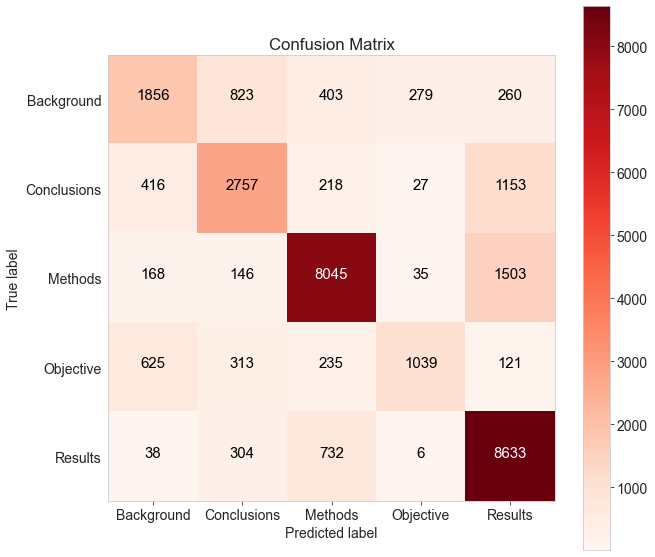

In [64]:
niffo_plotter.plot_confusion_matrix(y_true=etest_labels, y_predict=model_3_preds, classes=mat_class)

## Model 4: Combined Pretrained token Embedding and Character Embedding Model

**Score:**

`accuracy: 71.27260660361706`

`precision: 0.7098339081951474`

`recall: 0.7127260660361706`

`f1-score: 0.7088614422301344`

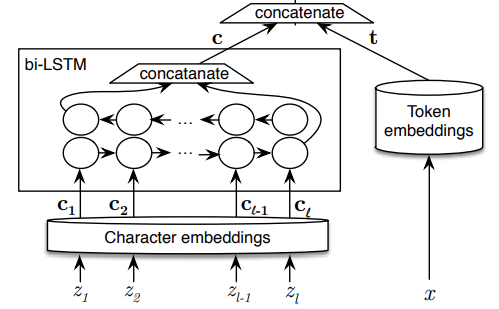

In [65]:
embedding_layer = hub.KerasLayer(pretrained_dir,
                                 trainable=False,
                                 name="embedding_layer")

In [66]:
char_vector_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=70,
                                                                          output_sequence_length=os_length)
char_vector_layer.adapt(train_chars)
vocab_size = len(char_vector_layer.get_vocabulary())

In [67]:
# Creating token embeddings model (t)
token_inputs = tf.keras.layers.Input(shape=[],
                                     dtype=tf.string,
                                     name="token_embedding_layer")
token_embeddings = embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128,
                                      activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,
                             token_outputs,
                             name="token_embeddings")


# Creating Character embeddings model (c)
char_inputs = tf.keras.layers.Input(shape=(1, ),
                                    dtype=tf.string,
                                    name="char_input")
char_vector = char_vector_layer(char_inputs)
char_embeddings = tf.keras.layers.Embedding(input_dim=70,
                                            output_dim=25,
                                            mask_zero=False,
                                            name="character_embedding_layer")(char_vector)

char_bi_ltsm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25), name="bi_lstm_layer")(char_embeddings)
char_model = tf.keras.Model(char_inputs,
                            char_bi_ltsm)
# Concatenate the layer (c + t)
lower_model = tf.keras.layers.Concatenate(name="concatenate_c_t")([token_model.output,
                                                                 char_model.output])
# Finishing model (output layer)
dropout = tf.keras.layers.Dropout(0.5)(lower_model)
x = tf.keras.layers.Dense(200, activation="relu")(dropout)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes,
                                activation="softmax",
                                name="output_layer")(x)

model_4 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input],
                         outputs=outputs, name="model_4")

# Compile the model
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.SGD(),
               metrics=["accuracy"])

In [68]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_embedding_layer (InputLa  [(None,)]           0           []                               
 yer)                                                                                             
                                                                                                  
 text_vectorization_3 (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                            

### Data Pipeline

In [69]:
train_concat_data = tf.data.Dataset.from_tensor_slices((train_sen, train_chars)) # Making concatenate data
train_concat_labels = tf.data.Dataset.from_tensor_slices(train_labels) # Making concatenate labels
train_concat_dataset = tf.data.Dataset.zip((train_concat_data,
                                            train_concat_labels)
                                          ).batch(32).prefetch(tf.data.AUTOTUNE) # Combining data and labels

In [70]:
test_concat_data = tf.data.Dataset.from_tensor_slices((test_sen, test_chars)) # Making concatenate data
test_concat_labels = tf.data.Dataset.from_tensor_slices(test_labels) # Making concatenate labels
test_concat_dataset = tf.data.Dataset.zip((test_concat_data,
                                            test_concat_labels)
                                          ).batch(32).prefetch(tf.data.AUTOTUNE) # Combining data and labels

In [71]:
val_concat_data = tf.data.Dataset.from_tensor_slices((val_sen, val_chars)) # Making concatenate data
val_concat_labels = tf.data.Dataset.from_tensor_slices(val_labels) # Making concatenate labels
val_concat_dataset = tf.data.Dataset.zip((val_concat_data,
                                            val_concat_labels)
                                          ).batch(32).prefetch(tf.data.AUTOTUNE) # Combining data and labels

In [72]:
train_concat_dataset, val_concat_dataset, test_concat_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting data

In [73]:
his_4 = model_4.fit(train_concat_dataset, epochs=10, validation_data=val_concat_dataset)

Epoch 1/10
5627/5627 [==============================] - 341s 59ms/step - loss: 1.2236 - accuracy: 0.5047 - val_loss: 0.8992 - val_accuracy: 0.6400
Epoch 2/10
5627/5627 [==============================] - 332s 59ms/step - loss: 0.9276 - accuracy: 0.6232 - val_loss: 0.8304 - val_accuracy: 0.6600
Epoch 3/10
5627/5627 [==============================] - 332s 59ms/step - loss: 0.8699 - accuracy: 0.6528 - val_loss: 0.7905 - val_accuracy: 0.6913
Epoch 4/10
5627/5627 [==============================] - 333s 59ms/step - loss: 0.8312 - accuracy: 0.6745 - val_loss: 0.7566 - val_accuracy: 0.7107
Epoch 5/10
5627/5627 [==============================] - 333s 59ms/step - loss: 0.8042 - accuracy: 0.6899 - val_loss: 0.7336 - val_accuracy: 0.7218
Epoch 6/10
5627/5627 [==============================] - 331s 59ms/step - loss: 0.7827 - accuracy: 0.7008 - val_loss: 0.7159 - val_accuracy: 0.7300
Epoch 7/10
5627/5627 [==============================] - 332s 59ms/step - loss: 0.7654 - accuracy: 0.7082 - val_loss: 0

In [74]:
model_4_preds = tf.argmax(model_4.predict(test_concat_dataset,
                                          verbose=1),
                          axis=1)

942/942 [==============================] - 30s 30ms/step


In [75]:
calculate_result(y_true=etest_labels, y_predict=model_4_preds)

{'accuracy': 74.01360544217687,
 'precision': 0.7362452366398555,
 'recall': 0.7401360544217687,
 'f1-score': 0.7354054811939644}

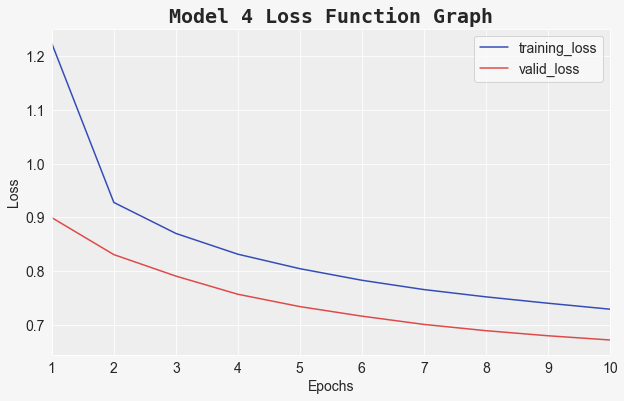

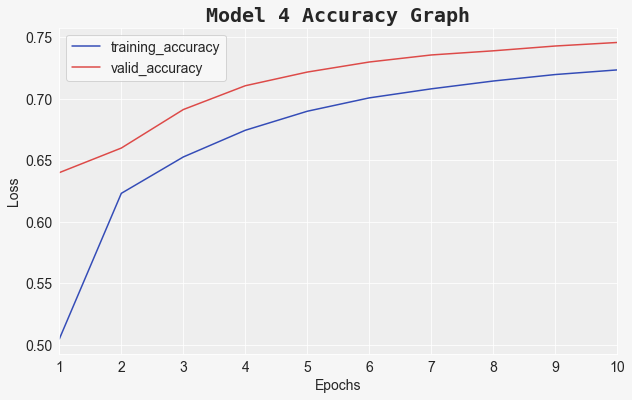

In [76]:
niffo_plotter.plot_model_history_loss(his_4, model_name="Model 4")
niffo_plotter.plot_model_history_accuracy(his_4, model_name="Model 4")

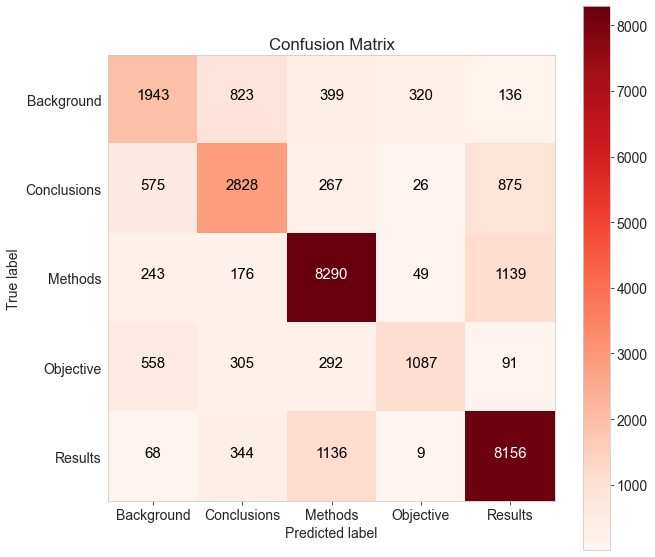

In [77]:
niffo_plotter.plot_confusion_matrix(y_true=etest_labels, y_predict=model_4_preds,classes=mat_class)

## Model 5: Replicating Research Paper Model Architecture
**Model architecture:** https://arxiv.org/pdf/1612.05251.pdf

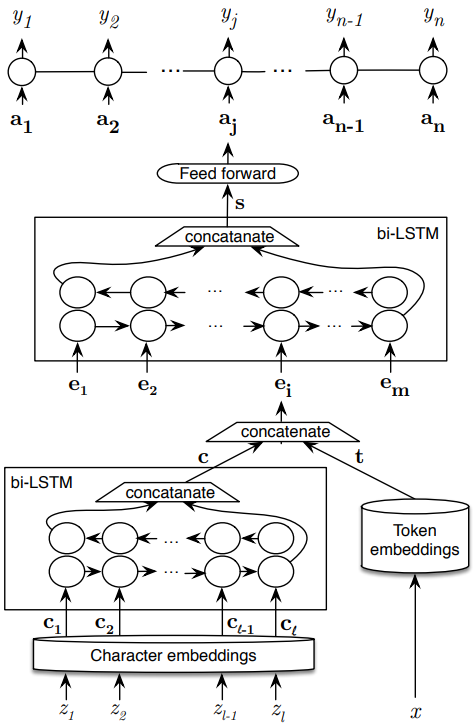

### Preparing Data PipeLine

In [5]:
full_data_dir = "data/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

### Preprocessing full data

In [6]:
full_train_data = preprocessing.get_raw_data(full_data_dir + "train.txt")
full_val_data = preprocessing.get_raw_data(full_data_dir + "dev.txt")
full_test_data = preprocessing.get_raw_data(full_data_dir + "test.txt")

In [7]:
len(full_train_data), len(full_val_data), len(full_test_data)

(2211861, 28932, 29493)

### Converting into pandas DataFrame

In [8]:
full_train_df = pd.DataFrame(full_train_data)
full_test_df = pd.DataFrame(full_test_data)
full_val_df = pd.DataFrame(full_val_data)

In [9]:
full_test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,many pathogenic processes and diseases are the...,0,10
1,BACKGROUND,it was recently demonstrated that supraphysiol...,1,10
2,BACKGROUND,"in the present study , we examined the associa...",2,10
3,BACKGROUND,"in addition , we compared plasma levels of map...",3,10
4,METHODS,a total of @ mi patients and @ control persons...,4,10


### Getting sentences

In [10]:
full_train_sen = full_train_df["text"].tolist()
full_test_sen = full_test_df["text"].tolist()
full_val_sen = full_val_df["text"].tolist()

In [11]:
full_train_sen[:2]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .']

### Making numerical labels

In [12]:
ohe = OneHotEncoder(sparse=False)
full_train_labels = ohe.fit_transform(full_train_df["target"].to_numpy().reshape(-1, 1))
full_test_labels = ohe.fit_transform(full_test_df["target"].to_numpy().reshape(-1, 1))
full_val_labels = ohe.fit_transform(full_val_df["target"].to_numpy().reshape(-1, 1))

### Encoding labels

In [13]:
label_encoder = LabelEncoder()
full_etrain_labels = label_encoder.fit_transform(full_train_df["target"].to_numpy())
full_etest_labels = label_encoder.fit_transform(full_test_df["target"].to_numpy())
full_eval_labels = label_encoder.fit_transform(full_val_df["target"].to_numpy())

### Checking distributions

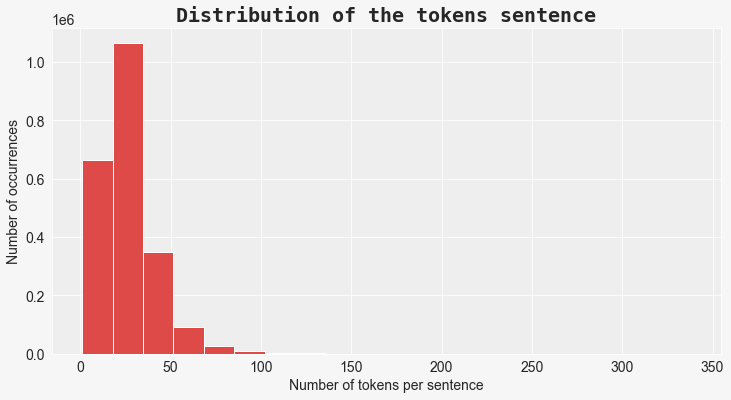

In [14]:
full_sen_len = [len(sen.split()) for sen in full_train_sen]
niffo_plotter.plot_histogram(data=full_sen_len,
                             xlabel="Number of tokens per sentence",
                             ylabel="Number of occurrences",
                             title="Distribution of the tokens sentence",
                             bins=20)

In [15]:
# The graph represents taking 95% of the data is safe for the sequences length output
full_out_seq_len = int(np.percentile(full_sen_len, 95))
full_out_seq_len

54

### Creating characters data

In [16]:
full_train_chars = [preprocessing.split_chars(sen) for sen in full_train_sen]
full_val_chars = [preprocessing.split_chars(sen) for sen in full_val_sen]
full_test_chars = [preprocessing.split_chars(sen) for sen in full_test_sen]

In [17]:
full_train_chars[:2][:20]

['t h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .',
 't h i s   p a p e r   d e s c r i b e s   t h e   d e s i g n   a n d   e v a l u a t i o n   o f   p o s i t i v e   o u t l o o k   ,   a n   o n l i n e   p r o g r a m   a i m i n g   t o   e n h a n c e   t h e   s e l f - m a n a g e m e n t   s k i l l s   o f   g a y   m e n   l i v i n g   w i t h   h i v   .']

In [18]:
# Total Lines one hot 
full_train_total_lines_one_hot = tf.one_hot(full_train_df["total_lines"].to_numpy(), depth=24)
full_val_total_lines_one_hot = tf.one_hot(full_val_df["total_lines"].to_numpy(), depth=24)
full_test_total_lines_one_hot = tf.one_hot(full_test_df["total_lines"].to_numpy(), depth=24)

# Liner number one hot
full_train_line_numbers_one_hot = tf.one_hot(full_train_df["line_number"].to_numpy(), depth=16)
full_val_line_numbers_one_hot = tf.one_hot(full_val_df["line_number"].to_numpy(), depth=16)
full_test_line_numbers_one_hot = tf.one_hot(full_test_df["line_number"].to_numpy(), depth=16)

### Preparing datasets

In [19]:
# Training dataset
full_train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((full_train_line_numbers_one_hot,
                                                                full_train_total_lines_one_hot,
                                                                full_train_sen,
                                                                full_train_chars))
full_train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(full_train_labels)
full_train_pos_char_token_dataset = tf.data.Dataset.zip((full_train_pos_char_token_data, full_train_pos_char_token_labels))
full_train_pos_char_token_dataset = full_train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
full_val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((full_val_line_numbers_one_hot,
                                                              full_val_total_lines_one_hot,
                                                              full_val_sen,
                                                              full_val_chars))
full_val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(full_val_labels)
full_val_pos_char_token_dataset = tf.data.Dataset.zip((full_val_pos_char_token_data, full_val_pos_char_token_labels))
full_val_pos_char_token_dataset = full_val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Testing dataset
full_test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((full_test_line_numbers_one_hot,
                                                              full_test_total_lines_one_hot,
                                                              full_test_sen,
                                                              full_test_chars))
full_test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(full_test_labels)
full_test_pos_char_token_dataset = tf.data.Dataset.zip((full_test_pos_char_token_data, full_test_pos_char_token_labels))
full_test_pos_char_token_dataset = full_test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Check input shapes
full_train_pos_char_token_dataset, full_val_pos_char_token_dataset, full_test_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 16), (None, 24), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 16), (None, 24), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 16), (None, 24), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

### Pre-model layers

In [20]:
# Pretrained token embedding layer
pre_embedding_layer = hub.KerasLayer("Pretrained/universal-sentence-encoder_4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [21]:
# character vectorization
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=70,
                                    output_sequence_length=290,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")
char_vectorizer.adapt(full_train_chars)

In [22]:
# Create character embedding layer
char_embed = tf.keras.layers.Embedding(input_dim=70,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

In [23]:
from tensorflow.keras import layers

# Token model
token_inputs = layers.Input(shape=[], dtype="string", name="token_model")
token_embeddings = pre_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# Char embedding model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_model")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Line numbers model
line_number_inputs = layers.Input(shape=(16,), dtype=tf.int32, name="line_number_model")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# Total lines model
total_lines_inputs = layers.Input(shape=(24,), dtype=tf.int32, name="total_lines_model")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# Concat
combined_embeddings = layers.Concatenate(name="token_char_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# combined concat
z = layers.Concatenate(name="positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# Model 5
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [24]:
# Compiling model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"])

In [25]:
model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_model (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_model (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_model[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_model[0][0]']      

In [26]:
his_5 = model_5.fit(full_train_pos_char_token_dataset,
                              epochs=10,
                              validation_data=full_val_pos_char_token_dataset)

Epoch 1/10
69121/69121 [==============================] - 4044s 58ms/step - loss: 0.9859 - accuracy: 0.7967 - val_loss: 0.9332 - val_accuracy: 0.8317
Epoch 2/10
69121/69121 [==============================] - 4006s 58ms/step - loss: 0.9307 - accuracy: 0.8372 - val_loss: 0.9169 - val_accuracy: 0.8439
Epoch 3/10
69121/69121 [==============================] - 4016s 58ms/step - loss: 0.9181 - accuracy: 0.8459 - val_loss: 0.9072 - val_accuracy: 0.8502
Epoch 4/10
69121/69121 [==============================] - 4011s 58ms/step - loss: 0.9102 - accuracy: 0.8513 - val_loss: 0.9005 - val_accuracy: 0.8545
Epoch 5/10
69121/69121 [==============================] - 4001s 58ms/step - loss: 0.9048 - accuracy: 0.8549 - val_loss: 0.8965 - val_accuracy: 0.8569
Epoch 6/10
69121/69121 [==============================] - 4000s 58ms/step - loss: 0.9009 - accuracy: 0.8574 - val_loss: 0.8925 - val_accuracy: 0.8586
Epoch 7/10
69121/69121 [==============================] - 4003s 58ms/step - loss: 0.8978 - accuracy:

In [27]:
model_5_preds = tf.argmax(model_5.predict(full_test_pos_char_token_dataset, verbose=1), axis=1)

922/922 [==============================] - 31s 32ms/step


In [28]:
calculate_result(y_true=full_etest_labels, y_predict=model_5_preds)

{'accuracy': 86.34252195436206,
 'precision': 0.8649508552169941,
 'recall': 0.8634252195436205,
 'f1-score': 0.8618896483854971}

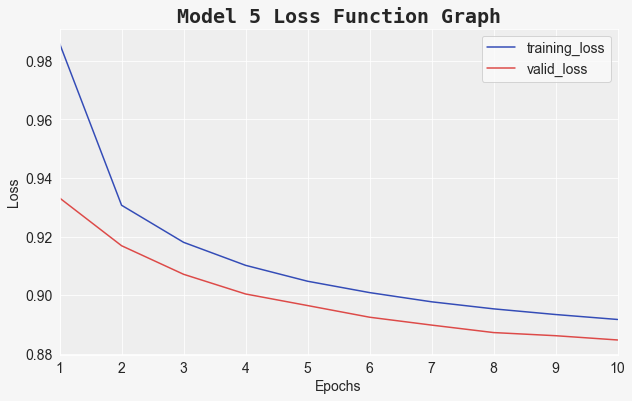

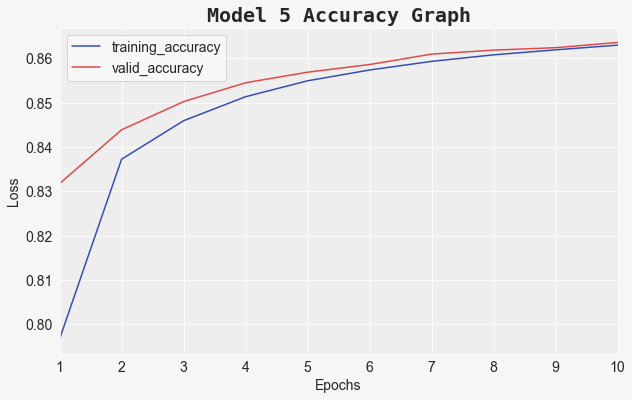

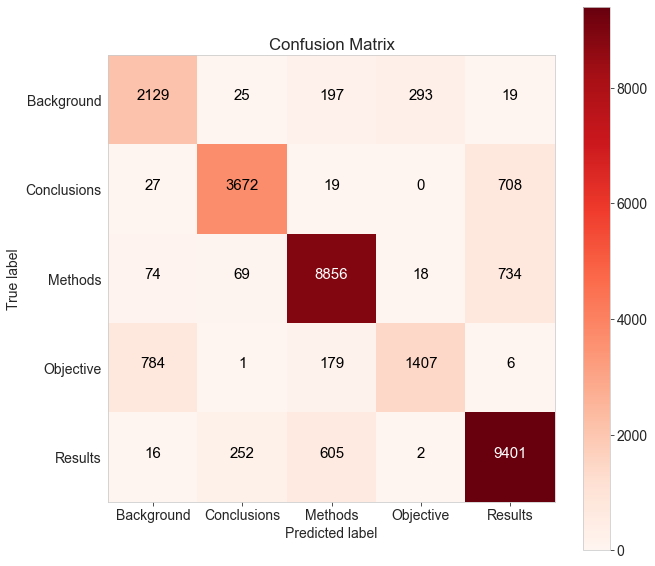

In [49]:
niffo_plotter.plot_model_history_loss(his_5, model_name="Model 5")
niffo_plotter.plot_model_history_accuracy(his_5, model_name="Model 5")
niffo_plotter.plot_confusion_matrix(y_true=full_etest_labels, y_predict=model_5_preds, classes=mat_class)